Acknowledge that the dataset herein is miniature and can be toyed with on Jupyter nb using a local machine, perhaps with single GPU. More realistic datasets would require API interfacing with a cluster and data engineering pipelines to display distributions of billions of params over time, or to run robust imputation methods for missing data as standalone endeavors before one even considers modeling.


In [163]:
import pandas as pd
import numpy as np

In [164]:
data = pd.read_csv("../data/train_sparked.csv")
X_test_nulls_raw = pd.read_csv("../data/test_sparked.csv")

In [165]:
data

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,...,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,Vehicle_Trim,Dealer_Listing_Price,NumOwners
0,warren,False,inventorycommandcenter,primemotorz,5.0,32,MI,48091,False,white,...,8.600069,Jeep,39319,grandcherokee,fairprice,None.,2015,High Altitude,30990.0,1.0
1,fargo,False,cadillaccertifiedprogram,gatewaychevroletcadillac,4.8,1456,ND,58103,True,black,...,2.920127,Cadillac,30352,xt5,gooddeal,Come take a look at our great pre-owned invent...,2017,NaN,34860.0,1.0
2,waukesha,False,jeepcertifiedprogram,wildechryslerjeepdodgeramampsubaru,4.8,1405,WI,53186,True,brilliantblackcrystalpearlcoat,...,28.107014,Jeep,38957,grandcherokee,gooddeal,Backed by a rigorous 125-point inspection by f...,2015,Laredo,23249.0,1.0
3,wentzville,False,inventorycommandcenter,centurydodgechryslerjeepram,4.4,21,MO,63385,False,diamondblackcrystalpearlcoat,...,59.816875,Jeep,20404,grandcherokee,gooddeal,Drop by to see us and you will quickly see how...,2018,Limited,31977.0,1.0
4,fayetteville,False,homenetautomotive,superiorbuickgmcoffayetteville,3.7,74,AR,72703,False,radiantsilvermetallic,...,98.665301,Cadillac,19788,xt5,gooddeal,"Luxury, Exterior Parking Camera Rear, Front Du...",2018,Luxury,33495.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6289,dearborn,True,sellityourself,abe,0.0,0,MI,48126,False,black,...,29.781968,Jeep,49000,grandcherokee,NaN,****ALL BLACK EDITION****You are viewing a bea...,2015,High Altitude,18699.0,NaN
6290,indianapolis,False,digitalmotorworksdmi,carmaxindianapolis,3.3,16,IN,46280,False,gray,...,4.840069,Jeep,20039,grandcherokee,fairprice,CarMax makes car buying easy and hassle-free. ...,2015,Limited,31998.0,1.0
6291,dublin,False,digitalmotorworksdmi,cadillacofdublin,4.1,20,OH,43017,True,black,...,184.921991,Cadillac,16278,xt5,gooddeal,Clean CARFAX. Certified. Black 2018 Cadillac X...,2018,Luxury,35674.0,0.0
6292,sandusky,False,digitalmotorworksdmi,fosterchevroletcadillac,4.9,278,OH,44870,False,black,...,73.868426,Cadillac,38146,xt5,greatdeal,Black 2017 Cadillac XT5 Luxury FWD 8-Speed Aut...,2017,Luxury,31995.0,2.0


In [166]:
data.dtypes

SellerCity               object
SellerIsPriv               bool
SellerListSrc            object
SellerName               object
SellerRating            float64
SellerRevCnt              int64
SellerState              object
SellerZip                 int64
VehCertified               bool
VehColorExt              object
VehColorInt              object
VehDriveTrain            object
VehEngine                object
VehFeats                 object
VehFuel                  object
VehHistory               object
VehListdays             float64
VehMake                  object
VehMileage                int64
VehModel                 object
VehPriceLabel            object
VehSellerNotes           object
VehYear                   int64
Vehicle_Trim             object
Dealer_Listing_Price    float64
NumOwners               float64
dtype: object

In [167]:
data.dtypes

SellerCity               object
SellerIsPriv               bool
SellerListSrc            object
SellerName               object
SellerRating            float64
SellerRevCnt              int64
SellerState              object
SellerZip                 int64
VehCertified               bool
VehColorExt              object
VehColorInt              object
VehDriveTrain            object
VehEngine                object
VehFeats                 object
VehFuel                  object
VehHistory               object
VehListdays             float64
VehMake                  object
VehMileage                int64
VehModel                 object
VehPriceLabel            object
VehSellerNotes           object
VehYear                   int64
Vehicle_Trim             object
Dealer_Listing_Price    float64
NumOwners               float64
dtype: object

In [168]:
X_test_nulls_raw

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,...,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,NumOwners
0,8622015,seneca,False,homenetautomotive,lakekeoweechryslerdodgejeepram,2.5,59,SC,29678,False,...,Gasoline,"['non-personal use reported', 'buyback protect...",143.991262,Cadillac,13625.0,xt5,gooddeal,Thank you for visiting another one of Lake Keo...,2018,1.0
1,8625693,bedford,False,inventorycommandcenter,northcoastautomall,4.7,2116,OH,44146,False,...,Gasoline,"['accident(s) reported', 'non-personal use rep...",138.770486,Jeep,42553.0,grandcherokee,gooddeal,This 2017 Jeep Grand Cherokee 4dr Limited 4x4 ...,2017,1.0
2,8625750,webster,False,jeepcertifiedprogram,marinachryslerdodgejeepmitsubishiram,3.9,46,NY,14580,True,...,E85 Flex Fuel,['buyback protection eligible'],31.951088,Jeep,48951.0,grandcherokee,gooddeal,Certified. Brilliant Black Crystal Pearlcoat 2...,2015,1.0
3,8626885,louisville,False,digitalmotorworksdmi,oxmoorfordlincoln,4.5,1075,KY,40222,False,...,Gasoline,['buyback protection eligible'],5.950127,Jeep,44179.0,grandcherokee,gooddeal,2015 Jeep Grand Cherokee ***THIS VEHICLE IS AT...,2015,1.0
4,8627430,palmyra,False,digitalmotorworksdmi,fckerbeckampsons,4.6,162,NJ,8065,False,...,Gasoline,"['non-personal use reported', 'buyback protect...",24.672986,Cadillac,22269.0,xt5,gooddeal,"AWD, CarFax One Owner! Navigation, Back-up Cam...",2018,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9992442,forestpark,False,homenetautomotive,curriechevy,4.8,1081,IL,60130,False,...,Gasoline,['buyback protection eligible'],18.091597,Jeep,24744.0,grandcherokee,gooddeal,granite crystal metallic clearcoat 2017 Jeep G...,2017,1.0
996,9993562,tampa,False,inventorycommandcenter,tampamitsubishi,4.0,240,FL,33614,False,...,Gasoline,"['non-personal use reported', 'buyback protect...",167.799676,Cadillac,5699.0,xt5,gooddeal,Tampa Mitsubishi is proud to offer this attrac...,2017,1.0
997,9994646,tampa,False,homenetautomotive,fermanacura,5.0,134,FL,33612,False,...,Gasoline,"['accident(s) reported', 'non-personal use rep...",46.215625,Cadillac,17985.0,xt5,gooddeal,*BRAND NEW* *2018* *CADILLAC* *XT5** LOADED WI...,2018,1.0
998,9997199,hamburg,False,inventorycommandcenter,townechryslerdodgejeepraminc,3.8,7,NY,14075,False,...,Diesel,['buyback protection eligible'],14.907535,Jeep,27.0,grandcherokee,fairprice,"Thousand?s of Vehicles, Positively Different E...",2018,1.0


In [169]:
y_train_nulls = data[["Dealer_Listing_Price", "Vehicle_Trim"]]
# y_train_null_id = y_train_nulls[data.isnull().any(axis=1)].index


X_train_nulls_raw = data.drop(
    ["Dealer_Listing_Price", "Vehicle_Trim"], axis=1
)  # nulls to indicate nulls present and raw to indicate ft are not numerically encoded yet
y_test_id_nulls_raw = X_test_nulls_raw["ListingID"]  # save for later
X_test_nulls_raw = X_test_nulls_raw.drop(["ListingID"], axis=1)

We note some features that only have two options and are binarized. Recall that OrdinalEncoder is suitable for categorical variables with a meaningful order. OneHotEncoder is suitable for categorical variables without a natural specific order and can be used to binarize. Seller rating is tricky to deal with as it's a numeric categorical feature as ratings are still an ordinal measure (what does 3.5 rating - 2.0 vs 1.0 + 5.0 rating even mean??) Before we tend to these pipelines simplify the codification of ext/int colors as there is a lot of repetition.


In [170]:
# Words to match and replace with the corresponding color name
colors_to_replace = [
    "blue",
    "red",
    "black",
    "silver",
    "white",
    "cashmere",
    "steel",
    "granite",
    "ivory",
    "amethyst",
    "green",
    "gray",
    "brown",
    "bronze",
    "auburn",
    "sangria",
    "mocha",
    "rhino",
]

# Constructing a regular expression pattern to match any portion containing the specified colors
pattern = "|".join(colors_to_replace)

# Replace any portion of the string containing 'blue', 'red', or 'black' etc with only the corresponding color name
# The r'\1' in the value parameter is a backreference to the matched portion, so it replaces the entire string with only the color name.
X_train_nulls_raw["VehColorExt"] = X_train_nulls_raw["VehColorExt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)
X_test_nulls_raw["VehColorExt"] = X_test_nulls_raw["VehColorExt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)

print(
    X_train_nulls_raw["VehColorExt"].unique(),
    len(X_train_nulls_raw["VehColorExt"].unique()),
)
print(
    X_test_nulls_raw["VehColorExt"].unique(),
    len(X_test_nulls_raw["VehColorExt"].unique()),
)

['white' 'black' 'silver' 'blue' 'red' 'granite' 'gray' 'brown' 'steel'
 'charcoal' 'velvet' 'green' 'bronze' 'rhino' nan 'ivory' 'amethyst'
 'sangria' 'maroon' 'cashmere' 'certifiedhemilthrpanoroofnav' 'purple'
 'certifiedlthrroofnavcamera' 'burgundy' 'auburn' 'gold' 'grey' 'pearl'
 'diamond' 'other' 'midnightsky' 'beige' 'tan' 'notspecified'
 'certifiedlthrpanoroofnavcamera' 'platinum' 'pewter' 'mocha'
 'shadowmetallic' 'gy' 'certifiedlthrpanoroofhotcoldseats' 'pink' 'billet'
 'certifiedroofcamerahtdseats' 'beigh' 'midnightskymetallic' 'unspecified'
 'brightsil'] 48
['black' 'blue' 'granite' 'silver' 'white' nan 'red' 'beige' 'amethyst'
 'gray' 'ivory' 'billet' 'rhino' 'deepcherry' 'sangria' 'bronze' 'green'
 'velvet' 'steel' 'cashmere' 'brown' 'auburn' 'grey' 'midnightsky'
 'burgundy' 'shadowmetallic' 'tan' 'notspecified' 'diamond' 'undetermined'
 'mocha'] 31


In [171]:
X_train_nulls_raw["VehColorInt"] = X_train_nulls_raw["VehColorInt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)
X_test_nulls_raw["VehColorInt"] = X_test_nulls_raw["VehColorInt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)

print(
    X_train_nulls_raw["VehColorExt"].unique(),
    len(X_train_nulls_raw["VehColorInt"].unique()),
)
print(
    X_test_nulls_raw["VehColorExt"].unique(),
    len(X_test_nulls_raw["VehColorInt"].unique()),
)

# Careful not to overreach and drop colors you do not see in the test set as it's meant to be beyond our purview. This was simply to cut down on complexity

['white' 'black' 'silver' 'blue' 'red' 'granite' 'gray' 'brown' 'steel'
 'charcoal' 'velvet' 'green' 'bronze' 'rhino' nan 'ivory' 'amethyst'
 'sangria' 'maroon' 'cashmere' 'certifiedhemilthrpanoroofnav' 'purple'
 'certifiedlthrroofnavcamera' 'burgundy' 'auburn' 'gold' 'grey' 'pearl'
 'diamond' 'other' 'midnightsky' 'beige' 'tan' 'notspecified'
 'certifiedlthrpanoroofnavcamera' 'platinum' 'pewter' 'mocha'
 'shadowmetallic' 'gy' 'certifiedlthrpanoroofhotcoldseats' 'pink' 'billet'
 'certifiedroofcamerahtdseats' 'beigh' 'midnightskymetallic' 'unspecified'
 'brightsil'] 38
['black' 'blue' 'granite' 'silver' 'white' nan 'red' 'beige' 'amethyst'
 'gray' 'ivory' 'billet' 'rhino' 'deepcherry' 'sangria' 'bronze' 'green'
 'velvet' 'steel' 'cashmere' 'brown' 'auburn' 'grey' 'midnightsky'
 'burgundy' 'shadowmetallic' 'tan' 'notspecified' 'diamond' 'undetermined'
 'mocha'] 22


In [172]:
X_train_nulls_raw.columns, X_train_nulls_raw.shape, X_test_nulls_raw.shape

(Index(['SellerCity', 'SellerIsPriv', 'SellerListSrc', 'SellerName',
        'SellerRating', 'SellerRevCnt', 'SellerState', 'SellerZip',
        'VehCertified', 'VehColorExt', 'VehColorInt', 'VehDriveTrain',
        'VehEngine', 'VehFeats', 'VehFuel', 'VehHistory', 'VehListdays',
        'VehMake', 'VehMileage', 'VehModel', 'VehPriceLabel', 'VehSellerNotes',
        'VehYear', 'NumOwners'],
       dtype='object'),
 (6294, 24),
 (1000, 24))

Now we focus on the text columns and use Word2Vec to study them. I left notes in spark.py if you want more details on rationale (doing it on this end as converting pyspark Vector type is hassle)


In [173]:
X_train_nulls_raw["VehSellerNotes"]

0                                                   None.
1       Come take a look at our great pre-owned invent...
2       Backed by a rigorous 125-point inspection by f...
3       Drop by to see us and you will quickly see how...
4       Luxury, Exterior Parking Camera Rear, Front Du...
                              ...                        
6289    ****ALL BLACK EDITION****You are viewing a bea...
6290    CarMax makes car buying easy and hassle-free. ...
6291    Clean CARFAX. Certified. Black 2018 Cadillac X...
6292    Black 2017 Cadillac XT5 Luxury FWD 8-Speed Aut...
6293    With Vroom, you can buy your next car from the...
Name: VehSellerNotes, Length: 6294, dtype: object

In [174]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
import nltk
import re

# https://radimrehurek.com/gensim/models/doc2vec.html
# https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


def tagDoc(df, col, tokens_only=False):
    # Using a custom tokenization to remove stop words
    # and other punctuation via regex
    df[col] = df[col].fillna("none")
    df[col] = df[col].replace("", "none")

    df[col] = df[col].apply(
        lambda text: [
            re.sub(r"[^a-zA-Z0-9]", "", token.lower())
            for token in word_tokenize(text)
            if token.lower() not in stop_words
        ]
    )

    # removing any resulting blank space entries like in  ['arsenic', '', 'cat'] --> ['arsenic', 'cat']
    df[col] = df[col].apply(lambda text: " ".join(text).split())

    # now each entry (document) of the col has words in our custom tokenized format:
    """
    DF now looks something like this (train shown here):
    0                                               [none]
    1    [come, take, look, great, preowned, inventory,...
    2    [backed, rigorous, 125point, inspection, facto...
    3    [drop, see, us, quickly, see, century, x27, sp...
    4    [luxury, exterior, parking, camera, rear, fron...
    .
    .
    .
    """

    for i, line in enumerate(df[col]):
        # print(line)
        if tokens_only:
            yield line
        else:
            # For training data, add tags
            # Example: TaggedDocument(words=['come', 'take', 'look', 'great', 'preowned', 'inventory', 'wwwgatewayfargocom'], tags=[1])
            yield gensim.models.doc2vec.TaggedDocument(line, [i])


def trainedWordModel(train_corpus, vector_size=100, min_count=3, epochs=40):
    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=min_count, epochs=epochs
    )

    # Essentially, the vocabulary is a list (accessible via model.wv.index_to_key)
    # of all of the unique words extracted from the training corpus.
    model.build_vocab(train_corpus)

    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    # Now, we can use the trained model to infer a vector for any piece of text by passing a list of words to the model.infer_vector function
    return model


def embed(model, df, col):
    for index, row in df.iterrows():
        try:
            df.at[index, col] = model.infer_vector(row[col])
        except:
            df.at[index, col] = np.zeros(model.vector_size)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gbert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [175]:
str2Vectorize = ["VehSellerNotes", "SellerName", "SellerCity"]
for col in str2Vectorize:
    train_corpus = list(tagDoc(X_train_nulls_raw, col, tokens_only=False))
    test_corpus = list(tagDoc(X_test_nulls_raw, col, tokens_only=True))
    # print(list(train_corpus)[0:3])
    model = trainedWordModel(train_corpus=train_corpus)
    embed(model, X_train_nulls_raw, col)
    embed(model, X_test_nulls_raw, col)

While we will stop here with NLP, one would consider using dimensionality reduction techniques to gauge the explainability of the encoding. Perhaps changes to vector lengths, min word counts in a corpus, etc for better discriminatory power. Formatting string data in these dense vectors can be used in ranking and recommender systems or in sentiment analysis, for example. To cut down on some complexity, we just take the L2 norm of the vector as a feature.


In [176]:
def embedNormals(df, col):
    for index, row in df.iterrows():
        try:
            df.at[index, col] = np.linalg.norm(row[col].astype(float))
        except:
            print(f"WARNING OF DOOM FOR {col} AT INDEX {index}")
            df.at[index, col] = 0.0


for col in str2Vectorize:
    embedNormals(X_train_nulls_raw, col)
    embedNormals(X_test_nulls_raw, col)

Before we proceed it is best to check correlation measures for catgorical and numerical features. We shall use Cramer's V Test for categorical features.


In [177]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import itertools

# https://en.wikipedia.org/wiki/Cram%C3%A9r's_V


def calculate_cramers_v(tabs):
    """
    Cramér's V varies from 0 (corresponding to no association between the variables)
    to 1 (complete association) and can reach 1 only when each variable is completely determined by the other.
    It may be viewed as the association between two variables as a percentage of their maximum possible variation.
    """
    confusion_matrix = tabs
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Adding checks to avoid division by zero
    if min((k - 1), (r - 1)) == 0 or phi2 == 0:
        return 0

    # This is the bias correction: https://en.wikipedia.org/wiki/Cram%C3%A9r's_V
    phi2 = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    # Adding checks to avoid division by zero
    if min((kcorr - 1), (rcorr - 1)) == 0:
        return 0

    return np.sqrt(phi2 / min((kcorr - 1), (rcorr - 1)))


categorical_variables = [
    "SellerIsPriv",
    "SellerListSrc",
    "SellerState",
    "SellerZip",
    "VehCertified",
    "VehColorExt",
    "VehColorInt",
    "VehDriveTrain",
    "VehEngine",
    "VehFeats",
    "VehFuel",
    "VehHistory",
    "VehMake",
    "VehModel",
    "SellerRating",
    "VehPriceLabel",
]

# Create an empty list to store the results
results_list = []

pairs = list(itertools.combinations(categorical_variables, 2))

for x, y in pairs:
    # creating confusion matrix data frame
    tabs = pd.crosstab(X_train_nulls_raw[x], X_train_nulls_raw[y])
    cV = calculate_cramers_v(tabs)

    if cV >= 0.7:
        results_list.append({"Variable 1": x, "Variable 2": y, "Cramer's V": cV})

# Create a DataFrame from the list
results_df = pd.DataFrame(results_list).sort_values(by=["Cramer's V"], ascending=False)

# Print the results DataFrame
print(results_df)

       Variable 1     Variable 2  Cramer's V
15        VehMake       VehModel    0.999642
0    SellerIsPriv  SellerListSrc    0.999523
8   VehDriveTrain        VehMake    0.997826
9   VehDriveTrain       VehModel    0.997826
2    SellerIsPriv      VehEngine    0.992047
11      VehEngine        VehMake    0.944243
12      VehEngine       VehModel    0.944243
13       VehFeats        VehMake    0.921695
14       VehFeats       VehModel    0.921695
10      VehEngine        VehFuel    0.885264
6     SellerState      SellerZip    0.845817
4   SellerListSrc      VehEngine    0.826024
5   SellerListSrc       VehFeats    0.812295
7   VehDriveTrain       VehFeats    0.781030
1    SellerIsPriv      SellerZip    0.776241
3   SellerListSrc   VehCertified    0.775266


The make (Cadillac/Jeep) and model (grandcherokee/xt5) of a car show complete association which is a no brainer -- Jeep Grand Chereokee or Cadillac XT5 are the models in train set! We drop the model feature in our encoding pipeline.

Listing if from a private seller (T/F) and seller listing source (8 options) identifier also show complete determination: it may come as no suprise as "certified program" shows up on about half the unique entries of SellerListSrc. We favor the binary feature and drop the listing src as it would add to even more sparsity.

Drive train and the vehicle make/model show complete determination. Jeeps and Caddys will may have unique drive trains or share certain configurations. We will keep make as model was already dropped. We shall instead drop drive train as it is nearly completely determined by which the vehicle make (Cadillac or Jeep) and suggests that AWD and 4WD/AWD could have been combined into one determination. Bluntly, knowing we have a FWD (or 2WD) option, we'd probably know which car make and model we're dealing with in this dataset.

Lastly, we choose to drop VehEngine as it is determined by make and model and has close association with fuel type.


Now we look at collinearity between numerical features. We opt for Spearman's over Pearson's coeff as the latter assumes underlying gaussians of each feature and linear relationships between the two. Spearman's coeff measures whether the relationship between variables is monotonic and doesn't strictly assume linearity.


In [178]:
X_train_nulls_raw.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,...,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,NumOwners
0,0.050986,False,inventorycommandcenter,0.027535,5.0,32,MI,48091,False,white,...,Gasoline,"['non-personal use reported', 'buyback protect...",8.600069,Jeep,39319,grandcherokee,fairprice,1.112797,2015,1.0
1,0.029163,False,cadillaccertifiedprogram,0.027312,4.8,1456,ND,58103,True,black,...,Gasoline,['buyback protection eligible'],2.920127,Cadillac,30352,xt5,gooddeal,3.006916,2017,1.0
2,0.043927,False,jeepcertifiedprogram,0.096601,4.8,1405,WI,53186,True,black,...,Gasoline,['buyback protection eligible'],28.107014,Jeep,38957,grandcherokee,gooddeal,4.632354,2015,1.0
3,0.048138,False,inventorycommandcenter,0.162524,4.4,21,MO,63385,False,black,...,Gasoline,"['non-personal use reported', 'buyback protect...",59.816875,Jeep,20404,grandcherokee,gooddeal,3.476145,2018,1.0
4,0.059283,False,homenetautomotive,0.028597,3.7,74,AR,72703,False,silver,...,Gasoline,"['non-personal use reported', 'buyback protect...",98.665301,Cadillac,19788,xt5,gooddeal,7.697643,2018,1.0


In [179]:
from scipy.stats import spearmanr
import itertools

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html


def calculate_spearman_corr(x, y):
    corr_p = spearmanr(x, y)
    return corr_p


numerical_variables = [
    "SellerRevCnt",
    "VehListdays",
    "VehMileage",
    "VehYear",
    "NumOwners",
    "VehSellerNotes",
    "SellerName",
    "SellerCity",
]

results_list = []
pairs = list(itertools.combinations(numerical_variables, 2))

for x, y in pairs:
    # Calculate Spearman's correlation for numerical features
    corr_value, p_val = calculate_spearman_corr(
        X_train_nulls_raw[x], X_train_nulls_raw[y]
    )
    # You can adjust the threshold as needed
    if abs(corr_value) >= 0.1:
        results_list.append(
            {
                "Variable 1": x,
                "Variable 2": y,
                "+/-": np.sign(corr_value),
                "|Spearman's Correlation|": abs(corr_value),
                "P-Value": p_val,
            }
        )

# Create a DataFrame from the list
results_df = pd.DataFrame(results_list).sort_values(
    by=["|Spearman's Correlation|"], ascending=False
)

# Print the results DataFrame
print(results_df)

     Variable 1      Variable 2  +/-  |Spearman's Correlation|        P-Value
2    VehMileage         VehYear -1.0                  0.540804   0.000000e+00
3    SellerName      SellerCity  1.0                  0.326432  3.493393e-156
0  SellerRevCnt  VehSellerNotes  1.0                  0.153641   1.493609e-34
1   VehListdays  VehSellerNotes  1.0                  0.117184   1.088385e-20


The p-value in statistics represents the probability of obtaining a result as extreme or more extreme than the observed result, assuming that the null hypothesis is true. In other words, it indicates how likely it is to observe the data if the null hypothesis is valid. A p-value near 0 in a statistical test typically indicates strong evidence against the null hypothesis. This suggests that the observed data is unlikely to have occurred by chance alone under the assumption that the null hypothesis is true. In this context, a small p-value indicates that there is ample evidence to reject the null hypothesis that there is no monotonic relationship between the two variables being compared.

BUT while it may come as no surprise that mileage and year are strongly monotonic in this data (it's likely that newer cars tend to have fewer mileage or cars with a little mileage are usually associated with the youngest models!) we will not drop any of these features as this test does not show causation; confounding variables or other underlying relationships can be playing into this.


Since we just are encoding here without fitting to anything there is no danger in leakage (not true if adding ML model predictions as another step) in combining the data together to get univeral encoding


In [180]:
X_nulls = pd.concat([X_train_nulls_raw, X_test_nulls_raw])
X_nulls.shape

(7294, 24)

In [181]:
X_nulls.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,...,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,NumOwners
0,0.050986,False,inventorycommandcenter,0.027535,5.0,32,MI,48091,False,white,...,Gasoline,"['non-personal use reported', 'buyback protect...",8.600069,Jeep,39319.0,grandcherokee,fairprice,1.112797,2015,1.0
1,0.029163,False,cadillaccertifiedprogram,0.027312,4.8,1456,ND,58103,True,black,...,Gasoline,['buyback protection eligible'],2.920127,Cadillac,30352.0,xt5,gooddeal,3.006916,2017,1.0
2,0.043927,False,jeepcertifiedprogram,0.096601,4.8,1405,WI,53186,True,black,...,Gasoline,['buyback protection eligible'],28.107014,Jeep,38957.0,grandcherokee,gooddeal,4.632354,2015,1.0
3,0.048138,False,inventorycommandcenter,0.162524,4.4,21,MO,63385,False,black,...,Gasoline,"['non-personal use reported', 'buyback protect...",59.816875,Jeep,20404.0,grandcherokee,gooddeal,3.476145,2018,1.0
4,0.059283,False,homenetautomotive,0.028597,3.7,74,AR,72703,False,silver,...,Gasoline,"['non-personal use reported', 'buyback protect...",98.665301,Cadillac,19788.0,xt5,gooddeal,7.697643,2018,1.0


In [182]:
X_nulls.columns, len(X_nulls.columns)

(Index(['SellerCity', 'SellerIsPriv', 'SellerListSrc', 'SellerName',
        'SellerRating', 'SellerRevCnt', 'SellerState', 'SellerZip',
        'VehCertified', 'VehColorExt', 'VehColorInt', 'VehDriveTrain',
        'VehEngine', 'VehFeats', 'VehFuel', 'VehHistory', 'VehListdays',
        'VehMake', 'VehMileage', 'VehModel', 'VehPriceLabel', 'VehSellerNotes',
        'VehYear', 'NumOwners'],
       dtype='object'),
 24)

In [183]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Define column subsets
categorical_cols = [
    "SellerIsPriv",
    "SellerState",
    "SellerZip",
    "VehCertified",
    "VehColorExt",
    "VehColorInt",
    "VehFeats",
    "VehFuel",
    "VehHistory",
    "VehMake",
]
ordinal_cols = ["SellerRating", "VehPriceLabel"]
numeric_cols = [
    "SellerRevCnt",
    "VehListdays",
    "VehMileage",
    "VehYear",
    "NumOwners",
    "VehSellerNotes",
    "SellerName",
    "SellerCity",
]

# Create transformers
categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True)),
    ]  # https://stackoverflow.com/questions/52008548/python-running-into-x-test-y-test-fit-errors
)

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("ord", ordinal_transformer, ordinal_cols),
        ("num", numeric_transformer, numeric_cols),
    ],
    remainder="drop",  # NOTE CRITICAL -- leave out the other features that showed multicollinearity: VehModel, SellerListSrc, VehDriveTrain, VehEngine
)

# Create a final pipeline with the preprocessor and any subsequent steps (e.g., a model)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # Add additional steps as needed, e.g., a machine learning model -- holding off as we want to do imputation study
    ]
)
X = final_pipeline.fit_transform(X_nulls)

We now turn to the target variable in our train and notice there are nans in both columns. We replace nans in the dealer list price column with in-group averages should the matching trim be available from the other column. So, if there is a missing list price I will get the average for the car trim that had those list prices, if any, and vice versa.


In [184]:
y_train_nulls["Vehicle_Trim"].unique(), len(y_train_nulls["Vehicle_Trim"].unique())

(array(['High Altitude', nan, 'Laredo', 'Limited', 'Luxury', 'Limited 4x4',
        'Altitude', 'Overland', 'Premium Luxury', 'Base', 'Summit', 'FWD',
        'SRT', 'Luxury AWD', 'Trailhawk', 'Sterling Edition', 'Platinum',
        'Laredo E', 'Luxury FWD', 'Trackhawk', '75th Anniversary',
        'Premium Luxury FWD', 'Platinum AWD', 'SRT Night',
        'Limited 75th Anniversary Edition', '75th Anniversary Edition',
        'Limited 75th Anniversary', 'Premium Luxury AWD', 'Upland',
        'Limited X'], dtype=object),
 30)

In [185]:
priceLookup = y_train_nulls.groupby("Vehicle_Trim")["Dealer_Listing_Price"].median()
pd.DataFrame(priceLookup)

,Dealer_Listing_Price
Vehicle_Trim,
75th Anniversary,26737.0
75th Anniversary Edition,29430.0
Altitude,28774.0
Base,31000.0
FWD,26715.0
High Altitude,33599.0
Laredo,23035.0
Laredo E,29100.0
Limited,27896.0


In [186]:
trimLookup = y_train_nulls.groupby("Dealer_Listing_Price")["Vehicle_Trim"].agg(
    pd.Series.mode
)
pd.DataFrame(trimLookup)

,Vehicle_Trim
Dealer_Listing_Price,
18289.0,Laredo
18294.0,Laredo
18450.0,Laredo
18495.0,Limited
18698.0,Laredo
...,...
88000.0,Trackhawk
88950.0,Trackhawk
89452.0,Trackhawk


In [187]:
y_train_nulls["Vehicle_Trim"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6294 entries, 0 to 6293
Series name: Vehicle_Trim
Non-Null Count  Dtype 
--------------  ----- 
5889 non-null   object
dtypes: object(1)
memory usage: 49.3+ KB


In [188]:
mia = y_train_nulls[y_train_nulls.isnull().any(axis=1)]
mia

,Dealer_Listing_Price,Vehicle_Trim
1,34860.0,NaN
20,41981.0,NaN
85,42921.0,NaN
132,44555.0,NaN
141,20746.0,NaN
...,...,...
6263,44960.0,NaN
6264,NaN,Luxury
6276,41891.0,NaN
6281,NaN,Luxury


In [189]:
y_train_nulls.iloc[282, :]

Dealer_Listing_Price    30998.0
Vehicle_Trim            Limited
Name: 282, dtype: object

In [190]:
defaultTrim = str(y_train_nulls.Vehicle_Trim.agg(pd.Series.mode)[0])
defaultPrice = y_train_nulls.Dealer_Listing_Price.median()

In [191]:
y_train_nulls.iloc[222]

Dealer_Listing_Price    23000.0
Vehicle_Trim                NaN
Name: 222, dtype: object

In [192]:
g = y_train_nulls.copy()

In [193]:
priceLookup

Vehicle_Trim
75th Anniversary                    26737.0
75th Anniversary Edition            29430.0
Altitude                            28774.0
Base                                31000.0
FWD                                 26715.0
High Altitude                       33599.0
Laredo                              23035.0
Laredo E                            29100.0
Limited                             27896.0
Limited 4x4                         30493.0
Limited 75th Anniversary            28999.0
Limited 75th Anniversary Edition    29988.0
Limited X                           47340.0
Luxury                              34996.5
Luxury AWD                          33996.0
Luxury FWD                          35530.0
Overland                            31893.0
Platinum                            44900.0
Platinum AWD                        41490.0
Premium Luxury                      36000.0
Premium Luxury AWD                  37690.0
Premium Luxury FWD                  36380.0
SRT                

In [194]:
trimLookup

Dealer_Listing_Price
18289.0       Laredo
18294.0       Laredo
18450.0       Laredo
18495.0      Limited
18698.0       Laredo
             ...    
88000.0    Trackhawk
88950.0    Trackhawk
89452.0    Trackhawk
89480.0    Trackhawk
89500.0    Trackhawk
Name: Vehicle_Trim, Length: 2877, dtype: object

In [158]:
trimLookup.get(18289.0)
g = y_train_nulls.copy()

In [195]:
import math

# https://stackoverflow.com/questions/68671852/best-way-to-iterate-through-elements-of-pandas-series



# Function to find the first model trim within the given tolerance


def find_model_trim(knownPrice):
    # both trim and price are unknown (dreadful label) but have covariates
    # will end up with both defaults or, depending on tolerance, variation
    # with this default
    if math.isnan(knownPrice):
        return defaultTrim

    tolerance = 0.04  # 4% tolerance

    # Try to find comparable trim for that price within a tolerance
    for trim, price in zip(priceLookup.index, priceLookup.to_numpy()):
        if abs(knownPrice - price) / knownPrice <= tolerance:
            return trim

    return defaultTrim


def find_model_price(knownTrim):
    # both trim and price are unknown (dreadful label) but have covariates
    # will end up with both defaults or, depending on tolerance, variation
    # with this default

    if knownTrim != knownTrim:
        return defaultPrice

    # Find the median price for that trim
    priceFound = priceLookup.get(knownTrim, default=-1)
    priceNew = priceFound + 500

    if priceFound == -1:
        # trim may not be in the corpus being used, attempt to
        # find price for something slightly newer (more $)
        upgrade = trimLookup.get(priceNew, default=defaultPrice)
        priceFound = upgrade
    
    # may be the case that multiple cars at the border price share that price
    if isinstance(priceFound, (int, float)):
        return priceFound  # Return the number directly
    elif isinstance(priceFound, (list, np.ndarray)) and len(priceFound) > 0:
        return priceFound[0]  # Return the first element of the array


for index in y_train_nulls[y_train_nulls["Vehicle_Trim"].isnull()].index:
    y_train_nulls.loc[index, "Vehicle_Trim"] = find_model_trim(
        y_train_nulls.loc[index, "Dealer_Listing_Price"]
    )


for index in y_train_nulls[y_train_nulls["Dealer_Listing_Price"].isnull()].index:
    y_train_nulls.loc[index, "Dealer_Listing_Price"] = find_model_price(
        y_train_nulls.loc[index, "Vehicle_Trim"]
    )

In [241]:
y_train_nulls.iloc[2061, :]

Dealer_Listing_Price       35530.0
Vehicle_Trim            Luxury FWD
Name: 2061, dtype: object

In [246]:
test = y_train_nulls.loc[mia.index]

In [238]:
y_train_nulls[y_train_nulls['Vehicle_Trim'] == 'Premium Luxury']

,Dealer_Listing_Price,Vehicle_Trim
14,35830.0,Premium Luxury
21,34782.0,Premium Luxury
34,39995.0,Premium Luxury
52,35280.0,Premium Luxury
73,36888.0,Premium Luxury
...,...,...
6258,33994.0,Premium Luxury
6262,37680.0,Premium Luxury
6275,32000.0,Premium Luxury
6277,36045.0,Premium Luxury


In [260]:
# Define column subsets for y
categorical_cols = [
    "Vehicle_Trim",
]
numeric_cols = [
    "Dealer_Listing_Price",
]

# Create transformers
categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),
    ]
)


numeric_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True)),
    ]  # https://stackoverflow.com/questions/52008548/python-running-into-x-test-y-test-fit-errors
)

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols),
    ],
)

# Create a final pipeline with the preprocessor and any subsequent steps (e.g., a model)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # Add additional steps as needed, e.g., a machine learning model -- holding off as we want to do imputation study
    ]
)
y_missing = final_pipeline.fit_transform(y_train_nulls)

AS expected (without using imputation within the pipeline) we should see some NaN


In [261]:
np.any(np.isnan(X))

True

In [262]:
X_train_nulls = X[: len(X_train_nulls_raw)]  # drop raw tag as now encoded
X_test_nulls = X[len(X_train_nulls_raw) :]
X_train_nulls.shape, X_test_nulls.shape

((6294, 3083), (1000, 3083))

In [263]:
np.any(np.isnan(X_train_nulls))

True

Now that we have encoded the data let's take a look at the distributions (before the compression from encoding)


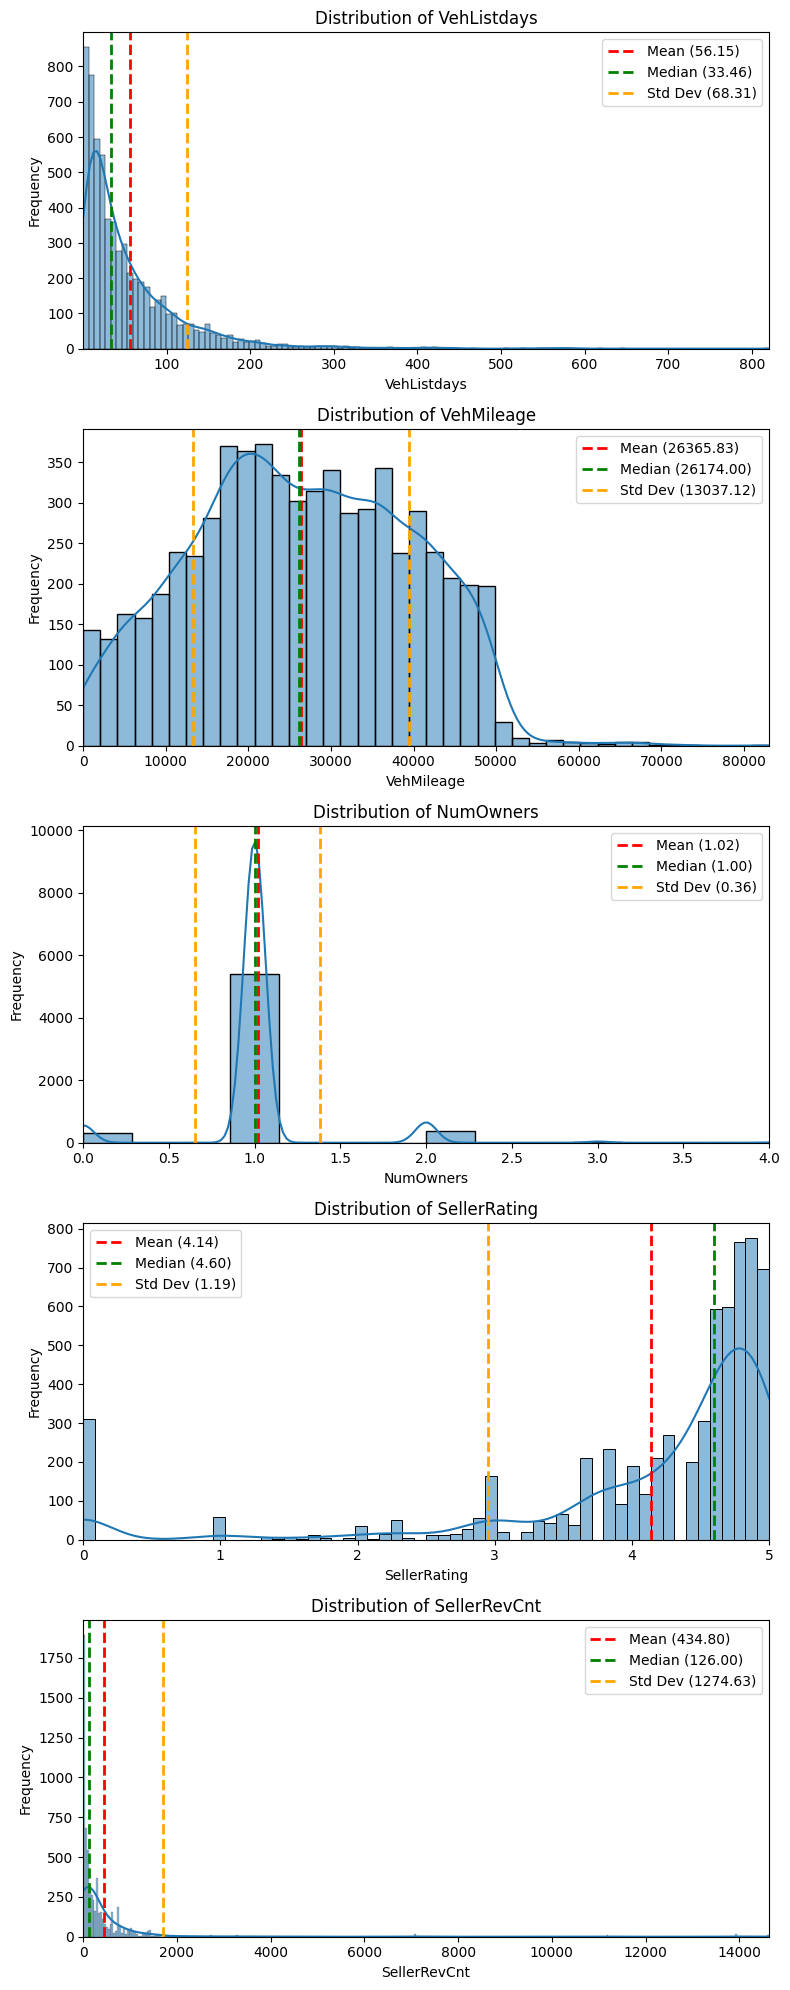

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

distCol = [
    "VehListdays",
    "VehMileage",
    "NumOwners",
    "SellerRating",
    "SellerRevCnt",
]
# Set up subplots -- NOTE: Dealer_Listing_Price is part of what we want to predict!
fig, axes = plt.subplots(nrows=len(distCol), ncols=1, figsize=(8, 4 * len(distCol)))

## Plot distribution and statistics for each column
for i, column in enumerate(distCol):
    # Plot distribution
    sns.histplot(X_train_nulls_raw[column], kde=True, ax=axes[i])

    # Calculate statistics
    mean_value = X_train_nulls_raw[column].mean()
    median_value = X_train_nulls_raw[column].median()
    std_dev_value = X_train_nulls_raw[column].std()

    # Plot major statistics below the distribution plot
    axes[i].axvline(
        mean_value,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean ({mean_value:.2f})",
    )
    axes[i].axvline(
        median_value,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Median ({median_value:.2f})",
    )
    axes[i].axvline(
        mean_value + std_dev_value,
        color="orange",
        linestyle="dashed",
        linewidth=2,
        label=f"Std Dev ({std_dev_value:.2f})",
    )
    axes[i].axvline(
        mean_value - std_dev_value, color="orange", linestyle="dashed", linewidth=2
    )
    axes[i].legend()

    # Set x-axis limits to the minimum and maximum values of the distribution
    axes[i].set_xlim(X_train_nulls_raw[column].min(), X_train_nulls_raw[column].max())

    # Set plot labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Distribution of {column}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

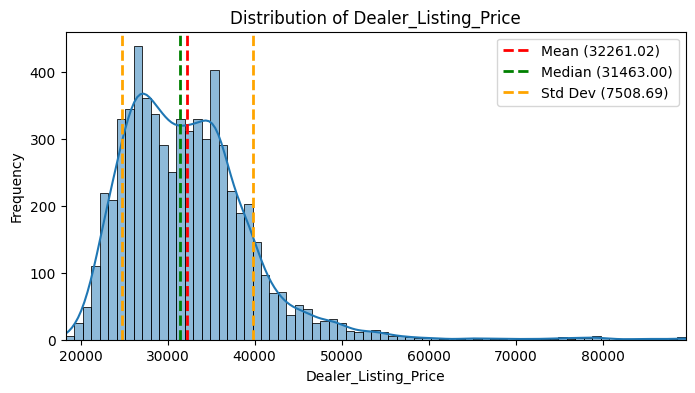

In [265]:
# Set up subplots
fig, ax = plt.subplots(figsize=(8, 4))

# Plot distribution
sns.histplot(y_train_nulls["Dealer_Listing_Price"], kde=True, ax=ax)

# Calculate statistics
mean_value = y_train_nulls["Dealer_Listing_Price"].mean()
median_value = y_train_nulls["Dealer_Listing_Price"].median()
std_dev_value = y_train_nulls["Dealer_Listing_Price"].std()

# Plot major statistics below the distribution plot
ax.axvline(
    mean_value,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean ({mean_value:.2f})",
)
ax.axvline(
    median_value,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median ({median_value:.2f})",
)
ax.axvline(
    mean_value + std_dev_value,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std Dev ({std_dev_value:.2f})",
)
ax.axvline(mean_value - std_dev_value, color="orange", linestyle="dashed", linewidth=2)
ax.legend()

# Set x-axis limits to the minimum and maximum values of the distribution
ax.set_xlim(
    y_train_nulls["Dealer_Listing_Price"].min(),
    y_train_nulls["Dealer_Listing_Price"].max(),
)

# Set plot labels and title
ax.set_xlabel("Dealer_Listing_Price")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Dealer_Listing_Price")

# Show the plot
plt.show()

None of the data distributions look Gaussian but standard scaling was used as it will not change the shape of the distribution.

https://stats.stackexchange.com/questions/453211/using-standardscaler-function-of-scikit-learn-library
https://stats.stackexchange.com/questions/290958/logistic-regression-and-scaling-of-features


Forgetting something? Yes, null values and outliers. Extensive outlier consideration will be omitted here due to time and knowing that logistic regression is kinder to us in this regard due to log-odds considerations. The standard scaler also blunted some of this effect in theory. As for imputation we will see which method would be best used to cover nan values comparing against various baseline for permuting holes in the data.

https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py


In [266]:
np.any(np.isnan(X_train_nulls))

True

In [267]:
np.any(
    np.isnan(
        np.where(
            np.isnan(X_train_nulls), np.nanmedian(X_train_nulls, axis=0), X_train_nulls
        )
    )
)

False

In [268]:
y_full_num = y_missing[:, -1].astype(float)
y_full_cat = y_missing[:, :-1].astype(int)

In [269]:
# Identify NaN values in the first column
nan_indices_1 = np.isnan(y_full_num)
print(np.where(nan_indices_1 == True))

# Identify NaN values in the encoded trim column
# will be futile as they were encoded already

(array([], dtype=int64),)


In [270]:
indexes_to_drop = []
for i in np.where(nan_indices_1 == True):
    indexes_to_drop.append(i)

In [271]:
# placeholder clean matrices -- can't have nulls in target variable so drop rows for both where that occurs. X was filled out with medians for a baseline
X_full = np.where(
    np.isnan(X_train_nulls),  # Condition: True where X_train_nulls is NaN
    np.nanmedian(
        X_train_nulls, axis=0
    ),  # Value to replace NaN with (column-wise median)
    X_train_nulls,  # Original values where condition is False
)
X_full = X_full[~np.isin(np.arange(X_full.shape[0]), indexes_to_drop)]
X_missing = X_train_nulls[
    ~np.isin(np.arange(X_train_nulls.shape[0]), indexes_to_drop)
]  # version of X_full but with nans (essentially our original X_train nulls without rows where missing one )
y_full = y_missing[~np.isin(np.arange(y_missing.shape[0]), indexes_to_drop)]
assert X_missing.shape == X_full.shape
X_full.shape, y_full.shape

((6294, 3083), (6294, 30))

In [272]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

N_SPLITS = 5

rng = np.random.RandomState(0)

X_missing = X_train_nulls.copy()
y_missing = y_full.copy()
mses_car = np.zeros(5)
stds_car = np.zeros(5)
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_bayes.py", line 295, in fit
    X, y = self._validate_data(X, y, dtype=[np.float64, np.float32], y_numeric=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1163, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1184, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1245, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (5035, 30) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_bayes.py", line 295, in fit
    X, y = self._validate_data(X, y, dtype=[np.float64, np.float32], y_numeric=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1163, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1184, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gbert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1245, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (5036, 30) instead.


In [ ]:
rng = np.random.RandomState(0)
# https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
# https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score

N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

x_labels = []
X_missing = X_train_nulls.copy()
y_missing = y_full.copy()
mses_car = np.zeros(5)
stds_car = np.zeros(5)

# Define your imputers
imputer_zero = SimpleImputer(
    missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
)

imputer_knn = KNNImputer(missing_values=np.nan, add_indicator=True)

imputer_mean = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)

imputer_median = SimpleImputer(
    missing_values=np.nan, strategy="median", add_indicator=True
)


# Define the pipeline for Full Data
pipeline_full_data = Pipeline([("regressor", regressor)])

pipeline_zero = Pipeline([("imputer", imputer_zero), ("regressor", regressor)])

pipeline_knn = Pipeline([("imputer", imputer_knn), ("regressor", regressor)])

pipeline_mean = Pipeline([("imputer", imputer_mean), ("regressor", regressor)])

pipeline_median = Pipeline([("imputer", imputer_median), ("regressor", regressor)])

# Define the pipelines for different imputation methods
pipelines = {
    "Full Data": pipeline_full_data,
    "Zero Imputation": pipeline_zero,
    "KNN Imputation": pipeline_knn,
    "Mean Imputation": pipeline_mean,
    "Median Imputation": pipeline_median,
}

# Evaluate each pipeline
mses_car = np.zeros(len(pipelines))
stds_car = np.zeros(len(pipelines))
x_labels = []

for i, (name, pipeline) in enumerate(pipelines.items()):
    print(name)
    if name == "Full Data":
        impute_scores = cross_val_score(
            pipeline, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
        )
    else:
        impute_scores = cross_val_score(
            pipeline,
            X_missing,
            y_missing,
            scoring="neg_mean_squared_error",
            cv=N_SPLITS,
        )
    mses_car[i] = impute_scores.mean()
    stds_car[i] = impute_scores.std()
    x_labels.append(name)

mses_car = mses_car * -1

Full Data


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

n_bars = len(mses_car)
xval = np.arange(n_bars)

fig, ax = plt.subplots()
colors = ["r", "g", "b", "orange", "black"]

# plot california dataset results
for j in xval:
    ax.barh(
        j,
        mses_car[j],
        xerr=stds_car[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax.set_title("Imputation Techniques with Car Data")
ax.set_yticks(xval)
ax.set_xlabel("MSE")
ax.invert_yaxis()
ax.set_yticklabels([""] * n_bars)

plt.show()